In [1]:
%load_ext watermark
%watermark -v -p torch

Python implementation: CPython
Python version       : 3.9.17
IPython version      : 8.14.0

torch: 2.0.1


## Import libraries

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt

In [4]:
# From local helper files
import sys
sys.path.insert(0, "../")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders

# Setting and Dataset

In [4]:

##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 20
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
# set_deterministic

In [6]:
##########################
### MNIST DATASET
##########################

resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])


train_loader, valid_loader, test_loader = get_dataloaders(batch_size=BATCH_SIZE,
                                                          name="MNIST",
                                                          validation_size_or_fraction=50000,
                                                          train_transforms=resize_transform,    
                                                          test_transforms=resize_transform)

print('size of sample train dataset:', len(train_loader))
# Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

size of sample train dataset: 500
Image batch dimensions: torch.Size([20, 1, 32, 32])
Image label dimensions: torch.Size([20])
Class labels of 10 examples: tensor([7, 6, 1, 9, 5, 1, 3, 8, 6, 7])


# Creation du model 

In [7]:
class LeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super().__init__()

        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3
        
        # feature extraction layers
        self.features = torch.nn.Sequential(

            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        # classifier layers
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [8]:
model = LeNet5(grayscale=True, num_classes=10)
model.to(device=DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

Epoch: 001/015 | Batch 0000/0500 | Loss: 2.3021
Epoch: 001/015 | Batch 0010/0500 | Loss: 2.2978
Epoch: 001/015 | Batch 0020/0500 | Loss: 2.1658
Epoch: 001/015 | Batch 0030/0500 | Loss: 1.9992
Epoch: 001/015 | Batch 0040/0500 | Loss: 1.7662
Epoch: 001/015 | Batch 0050/0500 | Loss: 1.2324
Epoch: 001/015 | Batch 0060/0500 | Loss: 1.0052
Epoch: 001/015 | Batch 0070/0500 | Loss: 1.0791
Epoch: 001/015 | Batch 0080/0500 | Loss: 0.5877
Epoch: 001/015 | Batch 0090/0500 | Loss: 0.3739
Epoch: 001/015 | Batch 0100/0500 | Loss: 0.4058
Epoch: 001/015 | Batch 0110/0500 | Loss: 0.3293
Epoch: 001/015 | Batch 0120/0500 | Loss: 0.2704
Epoch: 001/015 | Batch 0130/0500 | Loss: 0.7362
Epoch: 001/015 | Batch 0140/0500 | Loss: 0.3253
Epoch: 001/015 | Batch 0150/0500 | Loss: 0.1462
Epoch: 001/015 | Batch 0160/0500 | Loss: 0.2828
Epoch: 001/015 | Batch 0170/0500 | Loss: 0.5317
Epoch: 001/015 | Batch 0180/0500 | Loss: 0.2226
Epoch: 001/015 | Batch 0190/0500 | Loss: 0.2179
Epoch: 001/015 | Batch 0200/0500 | Loss:

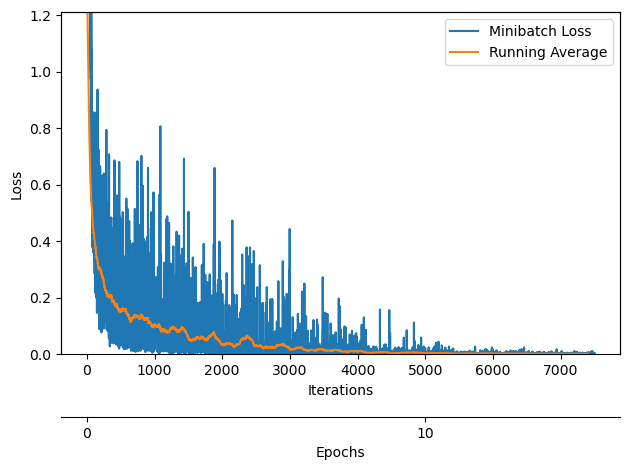

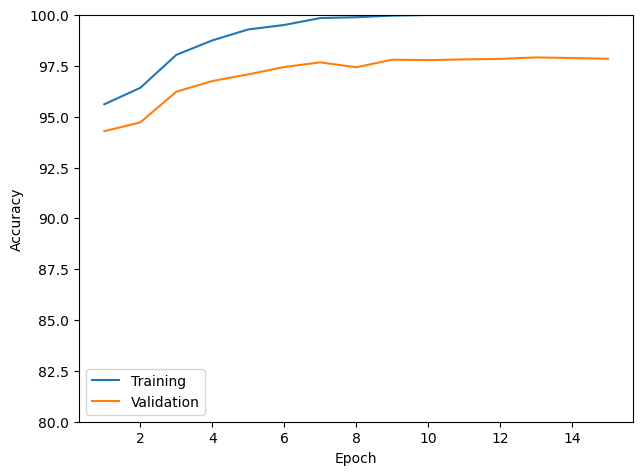

In [9]:

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
                                                    model=model,
                                                    num_epochs=NUM_EPOCHS,
                                                    train_loader=train_loader,
                                                    valid_loader=valid_loader,
                                                    test_loader=test_loader,
                                                    optimizer=optimizer,
                                                    device=DEVICE,
                                                    logging_interval=10)
# display training loss function 
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

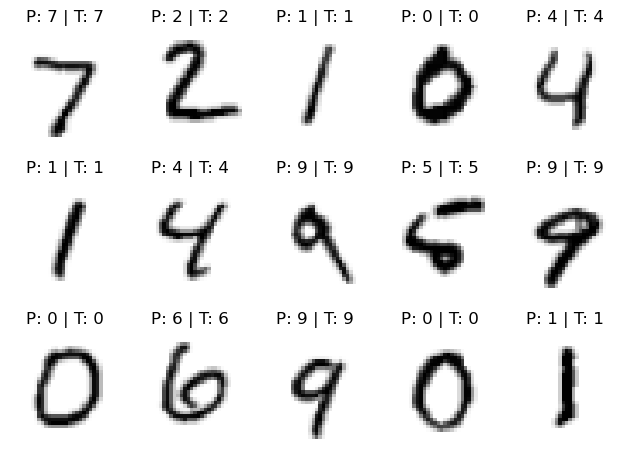

In [10]:
model.cpu()
show_examples(model=model, data_loader=test_loader)

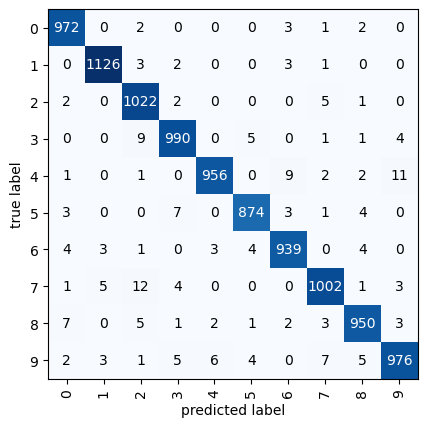

In [11]:
class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

# Save the model 

In [13]:
torch.save(obj=model.state_dict(),f="saved_data/model.pt")
torch.save(obj=optimizer.state_dict(),f="saved_data/optimizer.pt")
torch.save(obj=scheduler.state_dict(),f="saved_data/scheduler.pt")